In [3]:
import numpy as np
import pandas as pd

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'theme': 'white', 'transition': 'linear'})
cm.get('livereveal')

{'controls': 'false',
 'height': 5000,
 'mouseWheel': True,
 'scroll': 'true',
 'start_slideshow_at': 'selected',
 'theme': 'white',
 'transition': 'linear',
 'width': 1024}

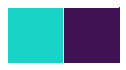

In [7]:
my_colors = ["#18d4c6", "#3e1253"]
sns.palplot(sns.color_palette(my_colors))
sns.set_palette(my_colors)

<h2 style="text-align: center;">Äpfel mit Birnen vergleichen</h2>

Wofür man Data Science braucht, wenn man einen Preisvergleich bauen will.


<table style='font-size:80%'>
 <caption><h2 style='align:right'>Wo ist eigentlich das Problem?</h2></caption>
 <tr><th>name</th><th>brand</th><th>category</th><th>price</th></tr>
 <tr bgcolor='yellow'><td>iPhone 6s 32 gb spacegrau</td><td>Apple</td><td>Handys ohne Vertrag</td><td>879.00</td></tr>
 <tr><td>iPhone 6 128GB</td><td></td><td>Mobiltelefone</td><td>749.00</td></tr>
 <tr><td>iPhone 6s</td><td>Apple (inc)</td><td>Handys</td><td>899.00</td></tr>
 <tr><td>iphone ohne Vertrag 6s plus</td><td>O2 (Apple)</td><td>Apple</td><td>929.00</td></tr>
 <tr bgcolor='yellow'><td> space grey iPhone 6s 32GB</td><td>Apple</td><td>Smartphones</td><td>899.00</td></tr>
 <tr><td>iPhone 6s Displayschutzfolie</td><td>Apple</td><td>Smartphone Zubehör</td><td>4.99</td></tr>
 <tr bgcolor='yellow'><td>iPhone 6s 32 Gb spacegray</td><td>Apple</td><td>Mobiltelefone</td><td>849.00</td></tr>
 <tr><td>iPhone 6s 32 Gb spacegray</td><td>Apple</td><td>Handys mit Vertrag</td><td>0.00</td></tr>
 <tr><td>iPhone 5s 32 Gb spacegray</td><td>Apple</td><td>Smartphones</td><td>799.00</td></tr>
</table>

Gruppieren von Angeboten unterschiedlicher Shops, so dass ein Preisvergleich sinnvoll wird.

<h2 style="text-align: center;">Beispiel mit echten Daten</h2>

In [8]:
from products import get_products_from_different_shops
products = get_products_from_different_shops()
products.shape

(71, 8)

In [9]:
from IPython.display import display, HTML
pd.set_option('max_colwidth', 200)
HTML(products[['name', 'price', 'ean']].sort_values(
    by='ean').to_html(index=False))

name,price,ean
Crucial Ballistix Sport 8GB kit 4GBx2 DDR3 PC3-12800 1600 240pin -bei bücher.de portofrei,54.99,649528755940
Crucial Ballistix Sport 8GB DDR3 Kit 1600MHz,52.42,649528755940
8GB KIT (4GBX2) DDR3 1600 MT/S,86.95,649528755940
1600 8GB(2x4) Crucial Balli. Sp,85.95,649528755940
DDR3RAM 2x 4GB DDR3-1600 Crucial Ballistix Sport,46.58,649528755940
DDR3RAM 2x 4GB DDR3-1600 Crucial Ballistix Sport,46.58,649528755940
Crucial Computer PC Arbeitsspeicher 8GB Crucial Ballistix Sport DDR3-1600 DIMM Dual Kit,74.99,649528755940
Crucial DDR3 8GB PC 1600 CL9 KIT (2x4GB) Crucial Ballistix Sport retail,48.39,649528755940
8GB KIT (4GBX2) DDR3 1600 MT/S,46.49,649528755940
Kingston DDR3 4GB PC 1600 CL11 Kingston ValueRAM ECC Registered,45.53,740617219470


## Was können wir tun?

Fangen wir mal mit etwas Einfachem an:

# Clustering

Wir brauchen nur ein Maß für die Ähnlichkeit zwischen zwei Angeboten und ein Clusteringverfahren.


## Was haben wir überhaupt für Daten

* Angebote mit gleicher EAN gehören wahrscheinlich zusammen
* Angebote aus einem Shop gehören wahrscheinlich nicht zusammen

## Wie gut lassen sich Matches/Nichtmatches unterscheiden?

* Preis
* Text (Kosinusdistanz)
* Ngramme

<h2 style="text-align: center;">Preisdistanz</h2>

In [164]:
from sklearn.metrics.pairwise import manhattan_distances
print(manhattan_distances(np.array([0, 1, 2, 3]).reshape(-1, 1)))

price_distances = manhattan_distances(
    products.price.reshape(-1, 1)).flatten()
print('')
print(price_distances)
distances['price'] = price_distances
matches = (manhattan_distances(
    products.ean.reshape(-1, 1)) == 0).astype(int).flatten()
print(matches)

[[ 0.  1.  2.  3.]
 [ 1.  0.  1.  2.]
 [ 2.  1.  0.  1.]
 [ 3.  2.  1.  0.]]

[   0.    861.9    33.93 ...,   76.46  671.07    0.  ]
[1 0 0 ..., 0 0 1]


<h2 style="text-align: center;">Text: Tfidf-Kosinusdistanz</h2>

In [165]:
from features import TextExtractor
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

texts = TextExtractor(
    text_cols=['name', 'brand', 'type']).transform(products)
tfidf = TfidfVectorizer().fit_transform(texts)
text_distances = 1.0 - linear_kernel(tfidf, tfidf).flatten()
print(text_distances)

[  1.11022302e-16   8.69245683e-01   8.24524955e-01 ...,   5.33635236e-01
   5.71542254e-01   1.11022302e-16]


<h2 style="text-align: center;">Text: Ngramdistanz</h2>

In [166]:
texts = TextExtractor(text_cols=['name']).transform(products)
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5)
                       ).fit_transform(texts)
ngram_distances = 1.0 - linear_kernel(tfidf, tfidf).flatten()
print(ngram_distances)

[ -6.66133815e-16   9.79052407e-01   9.86432505e-01 ...,   9.62262634e-01
   1.00000000e+00  -1.33226763e-15]


<h2 style="text-align: center;">Pandas DataFrame</h2>

In [167]:
distances = pd.DataFrame({
        'match': matches,
        'price': price_distances,
        'cosine': text_distances,
        'ngram': ngram_distances
})
# match == 0 -> no match
no_match = distances[distances.match == 0]
# match == 1 -> match
match = distances[distances.match == 1]

<h2 style="text-align: center;">Preisdistanz</h2>

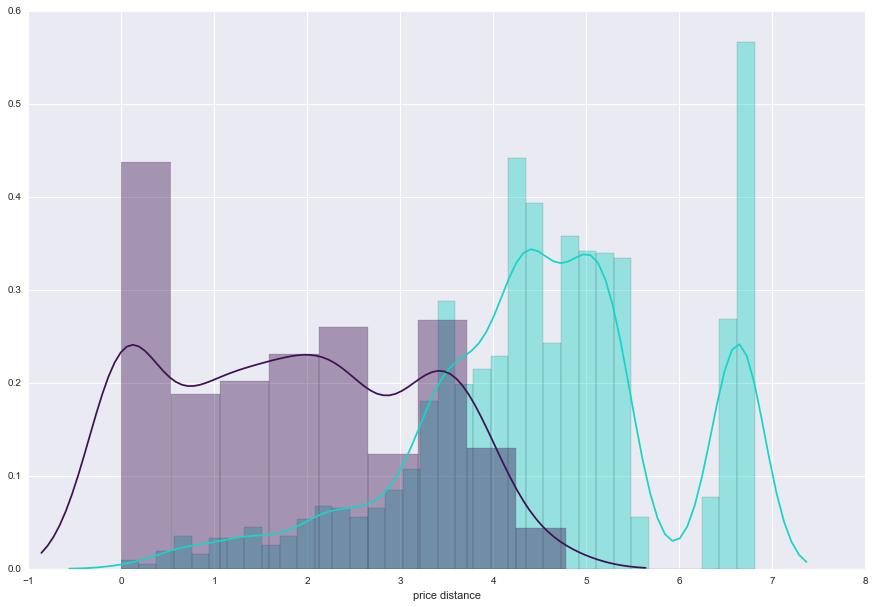

In [168]:
plt.figure(figsize=(15, 10))
legend = 'price distance'
a = sns.distplot(np.log(1.0 + no_match.price), axlabel=legend)
b = sns.distplot(np.log(1.0 + match.price), axlabel=legend)

<h2 style="text-align: center;">Text Kosinusdistanz</h2>

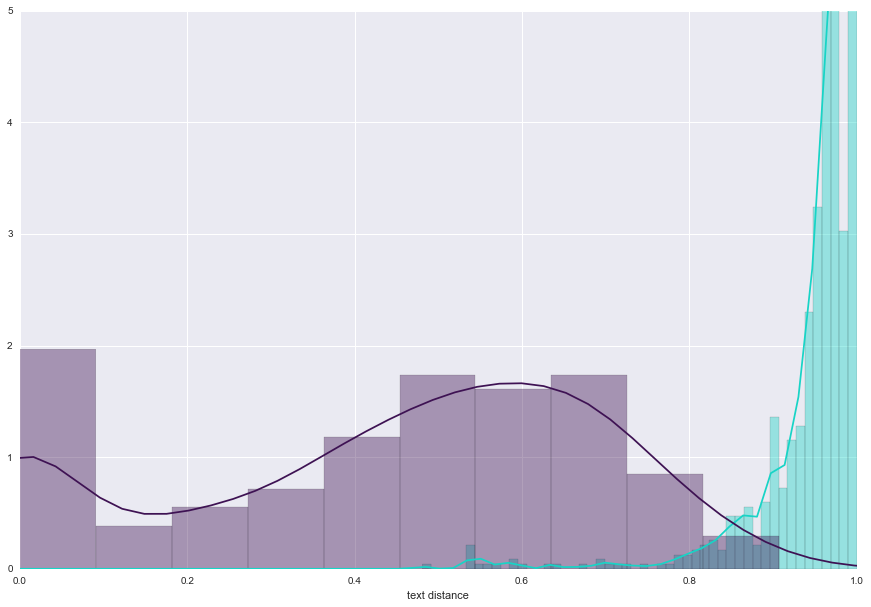

In [95]:
plt.figure(figsize=(15, 10))
legend = 'text distance'
sns.plt.xlim(0, 1)
sns.plt.ylim(0, 5)
a = sns.distplot(no_match.cosine, axlabel=legend)
b = sns.distplot(match.cosine, axlabel=legend)

<h2 style="text-align: center;">Ngramdistanz</h2>

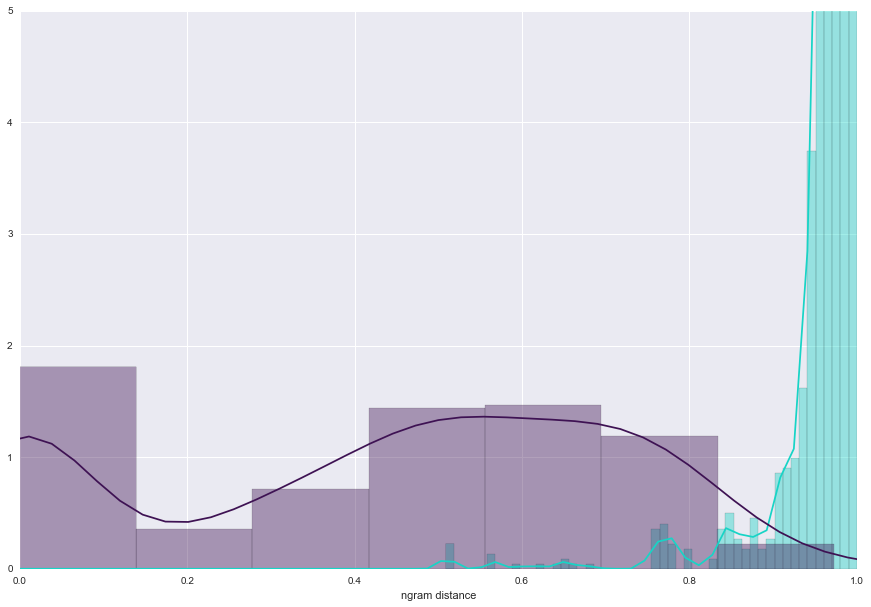

In [96]:
plt.figure(figsize=(15, 10))
legend = 'ngram distance'
sns.plt.xlim(0, 1)
sns.plt.ylim(0, 5)
a = sns.distplot(no_match.ngram, axlabel=legend)
b = sns.distplot(match.ngram, axlabel=legend)

<h2 style="text-align: center;">Text versus Preis in 2D</h2>

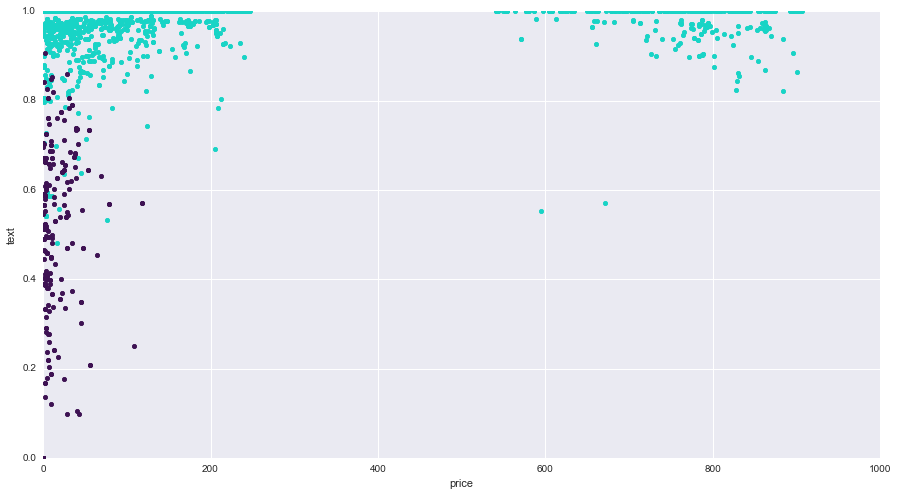

In [97]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.scatter(no_match.price, no_match.cosine, color=my_colors[0], label='text/price')
ax.scatter(match.price, match.cosine, color=my_colors[1], label='text/price')
ax.set_xlabel('price')
ax.set_ylabel('text')
ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.0, 1000)
plt.show()

<h2 style="text-align: center;">Seaborn pairplot</h2>

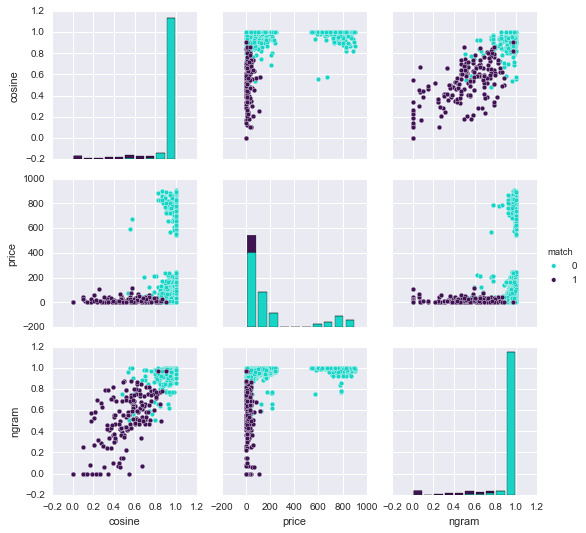

In [98]:
pp = sns.pairplot(distances, hue="match",
                  vars=['cosine', 'price', 'ngram'],
                  diag_kind="hist")

<h2 style="text-align: center;">Text vs Ngram vs Preis in 3D</h2>

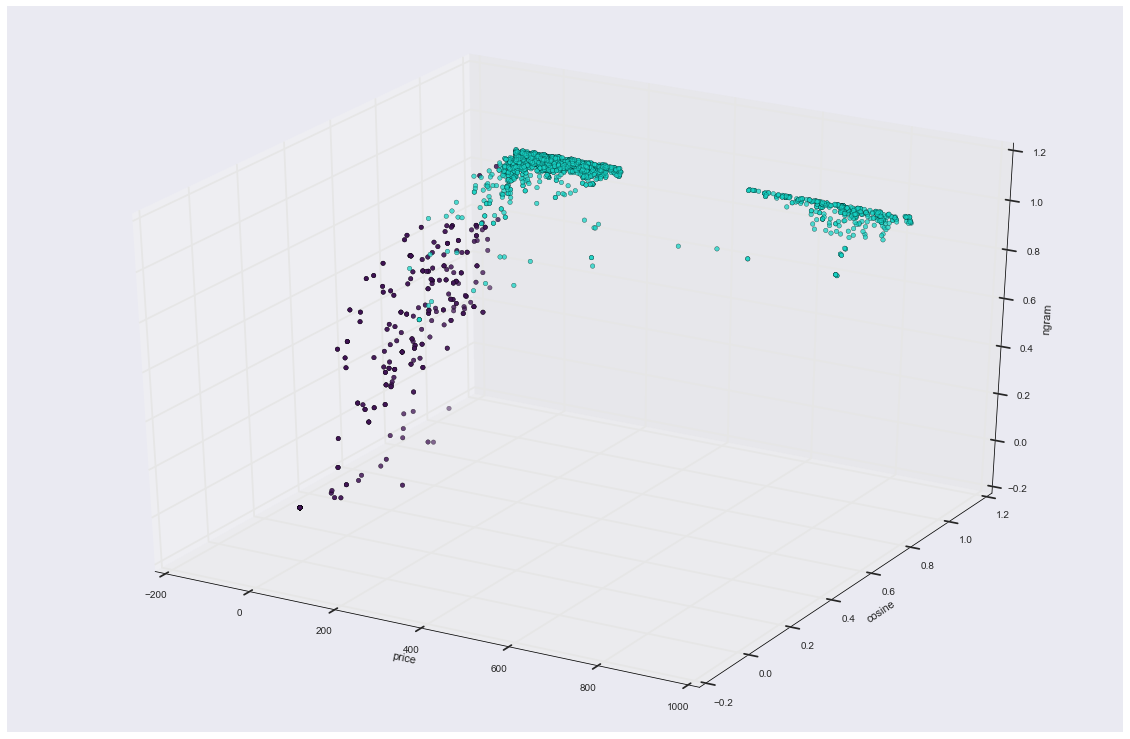

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(no_match.price, no_match.cosine, no_match.ngram, c=my_colors[0], alpha=0.5)
ax.scatter(match.price, match.cosine, match.ngram, c=my_colors[1], marker='o')
ax.set_xlabel('price');ax.set_ylabel('cosine');ax.set_zlabel('ngram')
plt.show()

<h2 style="text-align: center;">Kombination der Distanzen</h2>

In [99]:
from sklearn.preprocessing import MinMaxScaler
distances['price'] = MinMaxScaler().fit_transform(
    distances.price.reshape(-1, 1)).reshape(-1)
combined = np.sqrt(
    np.square(
        distances[['price', 'cosine', 'ngram']]).sum(axis=1))
distances['combined'] = MinMaxScaler().fit_transform(
    combined.reshape(-1, 1)).reshape(-1)
no_match = distances[distances.match == 0]
match = distances[distances.match == 1]

<h2 style="text-align: center;">Gesamtdistanz</h2>

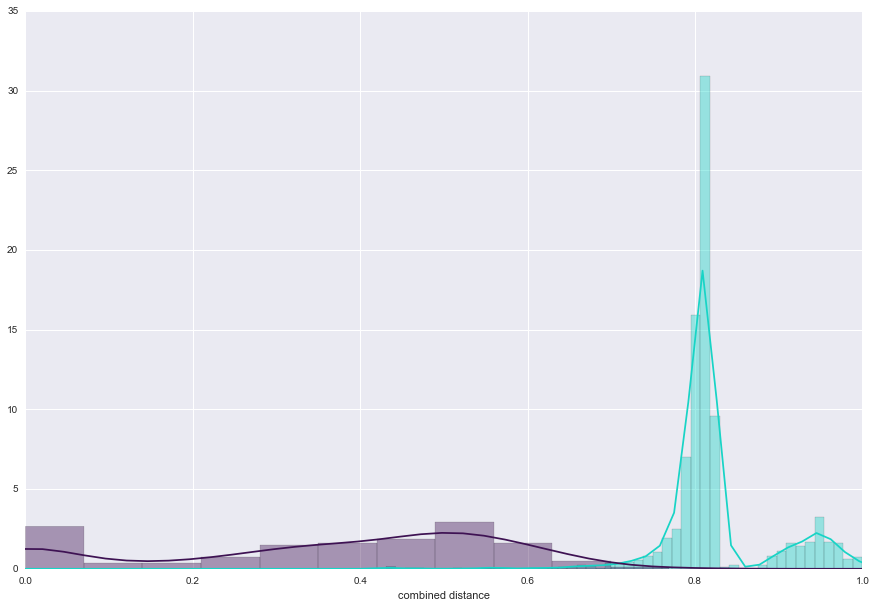

In [100]:
plt.figure(figsize=(15, 10))
legend = 'combined distance'
sns.plt.xlim(0, 1)
a = sns.distplot(no_match.combined, axlabel=legend)
b = sns.distplot(match.combined, axlabel=legend)

<h2 style="text-align: center;">Ok, was machen wir mit jetzt dieser Distanz?</h2>

<h2 style="text-align: center;">Clustern natürlich :)</h2>

<h2 style="text-align: center;">Transformation der Distanzen <br/>in einen Distanzgraphen</h2>

In [20]:
import networkx as nx
rows = products.shape[0]
X = distances.combined.reshape(rows, rows)
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

<h2 style="text-align: center;">Einfärben der Knoten nach EAN (Produktzugehörigkeit)</h2>

In [21]:
# create node color lookup dict
eans = set(products.ean)
colors = [int(c.replace('#', '0x'), 16) for c in
          sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in
                              products.ean)))

## Visualisierung des Distanzgraphen mit jgraph

In [130]:
import jgraph
from networkx.readwrite import json_graph
igraph_json = json_graph.node_link_data(G)
igraph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]}
                        for n in igraph_json['nodes']}
igraph_json['edges'] = [l for l in igraph_json['links']
                        if l['distance'] < 0.7 and l['distance'] > 0.0]
jgraph.draw(igraph_json, size=(800, 600), directed=False)

<h2 style="text-align: center;">Von Python nach Javascript via Json</h2>

In [133]:
import json
from pprint import pprint
# create json representation of graph, reformat node format
# and add color to nodes
d3_graph_json = json_graph.node_link_data(G)
d3_graph_json['nodes'] = [{'id': n['id'],
                           'color': node_colors[n['id']]}
                          for n in d3_graph_json['nodes']]
pprint(d3_graph_json['nodes'][:2])
# filter links
d3_graph_json['links'] = [l for l in d3_graph_json['links']
                          if l['distance'] < 0.7]
pprint(d3_graph_json['links'][:2])
# python json to javascript
from IPython.display import Javascript
Javascript("window.graph_json={};".format(
    json.dumps(d3_graph_json)))

[{'color': 14376791, 'id': 0}, {'color': 5755867, 'id': 1}]
[{'distance': 3.2626006455701125e-16, 'source': 0, 'target': 0},
 {'distance': 0.43172915396961103, 'source': 0, 'target': 7}]


<IPython.core.display.Javascript object>

In [26]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [41]:
%%javascript
function show_graph(d3, element) {
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    'h3 {',
    '  color: #1ABC9C;',
    '  text-align:center;',
    '  font-style: italic;',
    '  font-size: 14px;',
    '  font-family: "Helvetica";',
    '}',
    'thresholdSlider {',
    '  width: 10%;',
    '}',
    '</style>'
  ].join('\n');
    
  var threshold_form = [
    '<form>',
    '  <h3>',
    '    <input type="range" id="thresholdSlider" name="points" value="0.0" min="0" max="120" onchange="window.threshold(this.value)">',
    '  </h3>',
    '</form>',
  ].join('\n')

  element.append(style);
  //element.append('<h2 style="text-align: center;">Distanzgraph</h2>')
  element.append(threshold_form);
  element.append("<div id='chart1'></div>");

  var graph = window.graph_json;
  var graphRec = JSON.parse(JSON.stringify(graph));

  function restart() {
    link = link.data(graph.links);
    link.exit().remove();
    link.enter().insert("line", ".node").attr("class", "link");
    node = node.data(graph.nodes);
    node.enter().insert("circle", ".cursor").attr("class", "node").attr("r", 5).call(force.drag);
    force.start();
  };        
        
  function threshold(thresh) {
    console.log('raw threshold: ' + thresh);
    if (thresh > 0) {
        thresh = 0.01 * thresh;
    }
    console.log('threshold: ' + thresh);
    graph.links.splice(0, graph.links.length);

    for (var i = 0; i < graphRec.links.length; i++) {
      if (graphRec.links[i].distance > thresh) {graph.links.push(graphRec.links[i]);}
    }
    restart();
  };
        
  window.threshold = threshold;
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
}

window.show_graph = show_graph;

<IPython.core.display.Javascript object>

<h2 style="text-align: center;">Distanzgraph mit D3</h2>

In [134]:
%%javascript
require(['d3'], function(d3){
    window.show_graph(d3, element);
});

<IPython.core.display.Javascript object>

In [43]:
def show_clusters_old(products):
    ean_lookup = {ean: num for num, ean in enumerate(set(products.ean))}
    for cluster_id, group in products.groupby('predicted', sort=True):
        for _, row in group.iterrows():
            print('{} | {} | {}'.format(
                    row['name'][-49:].ljust(49),
                    str(row.price).ljust(6),
                    ean_lookup[row.ean]))
        print('----------------------------------------')

<h2 style="text-align: center;">Cluster als html anzeigen</h2>

In [105]:
def show_clusters(products):
    html = ''
    from IPython.display import display, HTML
    pd.set_option('max_colwidth', 200)
    for cid, group in products.groupby('predicted', sort=True):
        html += group[['name', 'price', 'ean']].to_html(
            index=False)
    return HTML(html)

<h2 style="text-align: center;">Cluster Scores</h2>

In [106]:
from sklearn import metrics
def clustering_scores(true, predicted):
    n = 10
    homogeneity = '{0:.3f}'.format(
        metrics.homogeneity_score(true, predicted))
    print('Homogeneity :   {}'.format(homogeneity))
    completeness = '{0:.3f}'.format(
        metrics.completeness_score(true, predicted))
    print('Completeness:   {}'.format(completeness))
    v_measure = '{0:.3f}'.format(
        metrics.v_measure_score(true, predicted))
    print('V-measure   :   {}'.format(v_measure))

<h2 style="text-align: center;">KMeans</h2>

In [145]:
from sklearn.cluster import KMeans, MiniBatchKMeans
kmeans = KMeans(n_clusters=len(eans), init='k-means++', max_iter=100,
                n_init=1)
products['predicted'] = kmeans.fit_predict(X)
clustering_scores(products.ean, products.predicted)

Homogeneity :   0.945
Completeness:   0.970
V-measure   :   0.957


In [146]:
show_clusters(products)

name,price,ean
Logitech Maus Logitech Mouse M100 Dark USB,14.46,5099206019140
Logitech M 100 Mouse USB black -bei bücher.de portofrei,12.99,5099206019140
LOGITECH Maus Mouse M100 Dark / USB / schwarz / G,19.90,5099206019140
Logitech M100 USB schwarz,9.65,5099206019140
Logitech M100 schwarz USB Maus,11.41,5099206019140
Logitech M100 schwarz USB Maus,11.41,5099206019140
Mouse M100 DARK,12.50,5099206019140
Logitech Maus M100/910-001604 schwarz,15.46,5099206019140
Logitech Kabel-Maus Mouse M100 in schwarz oder weiss,12.40,5099206019140
Mouse M100 DARK,14.95,5099206019140


In [285]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=len(eans), eigen_solver='arpack')
products['predicted'] = spectral_clustering.fit_predict(X)

/Users/jochen/miniconda3/envs/price_comparison/lib/python3.5/site-packages/sklearn/cluster/spectral.py:425: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [286]:
clustering_scores(products.ean, products.predicted)

Homogeneity :      1.000
Completeness:      1.000
V-measure   :      1.000


<h2 style="text-align: center;">AffinityPropagation</h2>

In [154]:
from sklearn.cluster import AffinityPropagation
products['predicted'] = AffinityPropagation().fit_predict(X)
clustering_scores(products.ean, products.predicted)

Homogeneity :   1.000
Completeness:   1.000
V-measure   :   1.000


In [123]:
show_clusters(products)

name,price,ean
Kingston DDR3 4GB PC 1600 CL11 Kingston ValueRAM ECC Registered,45.53,740617219470
KINGSTON D3 4GB 1600-11 REGP Sx8 KVR,45.67,740617219470
DDR3RAM 4GB DDR3-1600 Kingston ECC Reg CL11,43.32,740617219470
DDR3RAM 4GB DDR3-1600 Kingston ECC Reg CL11,43.32,740617219470
4GB 1600MHZ DDR3 ECC REG,41.94,740617219470
4GB 1600MHZ DDR3 ECC REG,70.95,740617219470
name,price,ean
Newstar TIS NewStar 10-30 1TFT 3Gelenke Silber Max.12KG FPMA-D935,93.42,8717371441340
Newstar TIS NewStar 10-30 1TFT 3Gelenke Silber Max.12KG FPMA-D935,93.42,8717371441340
Newstar FPMA D935 LCD LED TFT Tischhalterung,89.90,8717371441340


<p style="text-align: center;"><i class="icon-twitter icon-2x"> [Twitter: @ephes](http://twitter.com/ephes)</i></p>
<p style="text-align: center;"><i class="icon-github icon-2x"> [Github: ephes](https://github.com/ephes)</i></p>
<p style="text-align: center;"><i class="icon-envelope-alt icon-2x"> <a href="mailto:jochen@wersdoerfer.de">jochen@wersdoerfer.de</a></i></p>